# Intro
This script generates and analyses a network comprising lipid and polar metabolite quantifications. The networks will be compared against randomly generated networks and network metrics will be calculated. Furthermore, a community analysis will be made.

The script is inspired by Rui Benfeitas' notebook from the course "Omics Integration course 2020" offered by Scilifelab, NBIS National Bioinformatics Infrastructure Sweden. Link to notebook: https://nbisweden.github.io/workshop_omics_integration/session_topology/lab.html

# Import

In [45]:
# Preamble 
import pandas as pd
import scipy as sp
from scipy import stats
import numpy as np
from sklearn import preprocessing
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import StandardScaler
import sklearn, random, leidenalg
from sklearn.neighbors import KNeighborsClassifier
import igraph as ig

# Ploting
import seaborn as sns
import matplotlib.pyplot as plt

In [46]:
# Set variable for the cut-off value of the multiple hypothesis testing
alpha_thres = 0.0000001

# Load and prepare data

In [47]:
# Load lipid and metabolite data
data_lip = pd.read_csv("../data/02_lipidomics_data_tidy.csv", index_col=1)
info_lip = pd.read_csv("../data/02_lipidomics_data_info.csv", index_col=0)
sign_lipids = pd.read_csv("../data/07_sign_lipids.csv", index_col=0)
limma_lip = pd.read_csv("../data/06_limmatest_HIV.csv", index_col=0)

data_met = pd.read_csv("../data/02_metabolomics_sign_metabolites.csv", index_col=0)
info_met = pd.read_csv("../data/02_metabolomics_data_info.csv", index_col=0)

In [48]:
# Merge lipids and key metabolites
data_merge = pd.merge(data_lip, data_met, right_index=True, left_index=True)

# Filter control results
data_merge = data_merge[~data_merge.index.astype(str).str.endswith('Ctrl')]
data_merge

# Extracting only lipid and metabolite concentrations from the data set
data_merge.drop(data_merge.columns[0:2], axis=1, inplace=True)
data_lip_val = data_merge

# Transpose the value matrix
values = data_lip_val.transpose()
values

ID_Condition,1006_HIV_MetS,1008_HIV_MetS,1011_HIV_NoMetS,1025_HIV_NoMetS,1028_HIV_MetS,1029_HIV_NoMetS,1031_HIV_MetS,1034_HIV_MetS,1042_HIV_NoMetS,1043_HIV_MetS,...,2057_HIV_NoMetS,2058_HIV_MetS,2060_HIV_NoMetS,2061_HIV_NoMetS,2063_HIV_NoMetS,2066_HIV_MetS,2067_HIV_MetS,2077_HIV_NoMetS,2085_HIV_NoMetS,2097_HIV_NoMetS
CE(12:0),2.1771,0.6016,0.3922,0.6096,0.7088,0.7727,3.8545,7.1532,0.6734,2.0796,...,1.4548,0.1814,0.2518,1.2225,1.2665,1.0106,0.3622,0.7443,1.3688,0.9067
CE(14:0),1.3339,0.7570,0.6372,0.6856,1.1888,0.9800,1.3305,2.3445,0.7016,1.5603,...,1.6249,0.4027,0.3154,1.3252,0.9335,1.1928,0.6059,0.8176,1.1220,1.0489
CE(14:1),1.3729,0.4849,0.4751,0.7175,0.7438,0.8002,1.9779,2.1725,0.8938,1.5599,...,1.8053,0.2418,0.2906,1.5817,0.8638,1.0063,0.4309,0.8136,1.0752,0.9560
CE(15:0),1.0413,0.9753,0.8106,0.7484,1.1742,1.2999,0.9090,1.5154,0.7883,1.2137,...,1.5358,0.4728,0.4951,1.1325,1.0682,1.3850,0.6265,0.9190,1.1858,1.2273
CE(16:0),1.1034,1.3581,0.9916,0.7913,1.2248,1.1182,0.9312,1.5372,0.7144,1.1661,...,1.0655,0.8530,0.7405,1.0590,1.0256,1.0622,1.0321,1.1007,0.9120,1.0619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
glutamate,1.1329,0.9423,1.0215,0.7318,1.7492,0.9293,1.4126,1.1677,0.6362,0.9408,...,1.6234,2.8388,0.8806,1.5175,0.8284,1.9754,1.1915,0.7590,0.9464,0.8726
glycerate,0.3267,0.9185,0.9766,1.5083,1.1881,0.5463,1.0547,0.8261,1.0418,0.4521,...,1.4195,1.2127,1.1454,0.8058,0.9321,0.7471,0.6111,0.6995,0.7782,1.1319
isoleucine,0.9995,1.0290,0.8559,1.0764,1.2332,1.1011,1.1932,1.0098,0.8726,1.1796,...,1.3085,1.1234,0.9158,1.0000,0.8571,1.1874,0.9060,1.1714,1.3363,0.9475
palmitoyl-sphingosine-phosphoethanolamine (d18:1/16:0),0.6821,1.1799,0.8830,1.0750,0.5734,1.1350,0.7300,0.9720,1.2834,0.8333,...,0.7126,0.5060,1.4083,0.8472,1.1081,0.7974,1.0840,0.8861,1.0000,1.5232


In [49]:
# Make dataframe with groups for the biochemicals (lipid or metabolite)
frames = [info_lip["Group"], info_met["Group"]]
group_data = pd.concat(frames)

In [50]:
data_lip = pd.merge(group_data, values, right_index=True, left_index=True)
data_lip

,Group,1006_HIV_MetS,1008_HIV_MetS,1011_HIV_NoMetS,1025_HIV_NoMetS,1028_HIV_MetS,1029_HIV_NoMetS,1031_HIV_MetS,1034_HIV_MetS,1042_HIV_NoMetS,...,2057_HIV_NoMetS,2058_HIV_MetS,2060_HIV_NoMetS,2061_HIV_NoMetS,2063_HIV_NoMetS,2066_HIV_MetS,2067_HIV_MetS,2077_HIV_NoMetS,2085_HIV_NoMetS,2097_HIV_NoMetS
CE(12:0),lipid,2.1771,0.6016,0.3922,0.6096,0.7088,0.7727,3.8545,7.1532,0.6734,...,1.4548,0.1814,0.2518,1.2225,1.2665,1.0106,0.3622,0.7443,1.3688,0.9067
CE(14:0),lipid,1.3339,0.7570,0.6372,0.6856,1.1888,0.9800,1.3305,2.3445,0.7016,...,1.6249,0.4027,0.3154,1.3252,0.9335,1.1928,0.6059,0.8176,1.1220,1.0489
CE(14:1),lipid,1.3729,0.4849,0.4751,0.7175,0.7438,0.8002,1.9779,2.1725,0.8938,...,1.8053,0.2418,0.2906,1.5817,0.8638,1.0063,0.4309,0.8136,1.0752,0.9560
CE(15:0),lipid,1.0413,0.9753,0.8106,0.7484,1.1742,1.2999,0.9090,1.5154,0.7883,...,1.5358,0.4728,0.4951,1.1325,1.0682,1.3850,0.6265,0.9190,1.1858,1.2273
CE(16:0),lipid,1.1034,1.3581,0.9916,0.7913,1.2248,1.1182,0.9312,1.5372,0.7144,...,1.0655,0.8530,0.7405,1.0590,1.0256,1.0622,1.0321,1.1007,0.9120,1.0619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
glutamate,metabolite,1.1329,0.9423,1.0215,0.7318,1.7492,0.9293,1.4126,1.1677,0.6362,...,1.6234,2.8388,0.8806,1.5175,0.8284,1.9754,1.1915,0.7590,0.9464,0.8726
glycerate,metabolite,0.3267,0.9185,0.9766,1.5083,1.1881,0.5463,1.0547,0.8261,1.0418,...,1.4195,1.2127,1.1454,0.8058,0.9321,0.7471,0.6111,0.6995,0.7782,1.1319
isoleucine,metabolite,0.9995,1.0290,0.8559,1.0764,1.2332,1.1011,1.1932,1.0098,0.8726,...,1.3085,1.1234,0.9158,1.0000,0.8571,1.1874,0.9060,1.1714,1.3363,0.9475
palmitoyl-sphingosine-phosphoethanolamine (d18:1/16:0),metabolite,0.6821,1.1799,0.8830,1.0750,0.5734,1.1350,0.7300,0.9720,1.2834,...,0.7126,0.5060,1.4083,0.8472,1.1081,0.7974,1.0840,0.8861,1.0000,1.5232


In [51]:
any(data_lip.index.duplicated()) # No duplicates 

False

In [52]:
data_lip.groupby('Group').agg('count')[['1006_HIV_MetS']] 

,1006_HIV_MetS
Group,
lipid,917
metabolite,11


In [53]:
data_lip.shape # 928 variables, 200 samples + Group col

(928, 201)

# Association analysis
The initial network analysis will be an association analysis using Spearmans rank correlations. The network has a big chance of producing false positives, thus the Benjamin-Hochberg (BH) for false discovery rate (FDR).

In [54]:
# Check for rows with NA
values.isna().any().any() # False -> no rows with NA

False

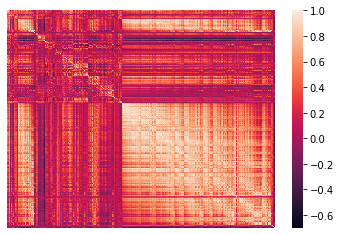

In [55]:
# Correlation and P val matrices choosing the non-parametric method spearmanns correrlation, matching data
Rmatrix, Pmatrix = sp.stats.spearmanr(values.T)
Rmatrix = pd.DataFrame(Rmatrix, index = values.index.copy(), columns = values.index.copy())

# Resulting R matrix and heatmap before FDR correction
sns.heatmap(Rmatrix, xticklabels=False , yticklabels=False)
plt.show()

Looking at the matrix of P values, the correlations in every corner except the lower right are not significant even before multiple hypothesis correction.

The P values will be adjusted based on the number of comparisons done which is 928^2 a little less than 1 mill. These numbers consider that the same correlation is computed twice (lip A vs lip B, and lip B vs lip A). If we were to include all correlations, we would thus be including many repeated analyses, and we are only interested in half of that above, and excluding the correlation of a feature with itself. At an error rate of 0.05, this means that the probability of finding at least one false positive is relative high. Thus, the p-values should be corrected.

In the following cell, the matrix of p*p features will be converted to a long matrix, concatenate both R and P for each correlation, and correct based on FDR (Benjamin-Hochberg).

In [56]:
# Make the P matrix
Pmatrix = pd.DataFrame(Pmatrix, index=values.index.copy(), columns=values.index.copy())

# Prepare P matrix
Psquared = Pmatrix.where(np.triu(np.ones(Pmatrix.shape),1).astype(np.bool))
Psquared.columns.name = 'Biomolecule2'
Pmatrix = Pmatrix.stack()
Pmatrix.index.names = ['v1','v2']
Pmatrix = Pmatrix.reset_index()
Pmatrix.columns = ['Biomolecule_1','Biomolecule_2','pvalue']

# Prepare R matrix
Rmatrix = Rmatrix.where(np.triu(np.ones(Rmatrix.shape),1).astype(np.bool))
Rmatrix.columns.name = 'Biomolecule2'
Rmatrix = Rmatrix.stack()
Rmatrix.index.names = ['v1','v2'] #Avoid stacked names colliding
Rmatrix = Rmatrix.reset_index()
Rmatrix.columns = ['Biomolecule_1','Biomolecule_2','R']

# Join both
PRmatrix = pd.merge(Rmatrix.copy(), Pmatrix.copy(), on=['Biomolecule_1','Biomolecule_2']) #Correlation matrix with both R and P
PRmatrix = PRmatrix.loc[PRmatrix.Biomolecule_1!=PRmatrix.Biomolecule_2].dropna()

# Multiple hypothesis correction computed on the P column
FDR = pd.DataFrame(multipletests(PRmatrix['pvalue'], method='fdr_bh', alpha=alpha_thres)[1], columns=['adj_pvalue'])
PRmatrix = pd.concat([ PRmatrix, FDR], axis=1)

PRmatrix

,Biomolecule_1,Biomolecule_2,R,pvalue,adj_pvalue
0,CE(12:0),CE(14:0),0.784893,5.004016e-43,4.545463e-42
1,CE(12:0),CE(14:1),0.701835,5.452706e-31,3.065351e-30
2,CE(12:0),CE(15:0),0.579732,2.368800e-19,8.670347e-19
3,CE(12:0),CE(16:0),0.469324,2.382123e-12,6.742725e-12
4,CE(12:0),CE(16:1),0.507372,1.757545e-14,5.394926e-14
...,...,...,...,...,...
430123,glycerate,palmitoyl-sphingosine-phosphoethanolamine (d18...,-0.035264,6.200831e-01,6.684456e-01
430124,glycerate,pimeloylcarnitine/3-methyladipoylcarnitine (C7...,0.099234,1.621002e-01,2.017601e-01
430125,isoleucine,palmitoyl-sphingosine-phosphoethanolamine (d18...,-0.282757,4.974549e-05,9.373970e-05
430126,isoleucine,pimeloylcarnitine/3-methyladipoylcarnitine (C7...,-0.156157,2.723617e-02,3.852789e-02


In [57]:
# Total number of correlations w/wo repetition
print("Total number of correlations w/wo repetition:", PRmatrix.shape[0])

Total number of correlations w/wo repetition: 430128


Considering the FDR as correction method, 185591 are significant, which at a FDR of 0.0000001 implies < 0.02 false positives (0.0000001*185591 = 0.018).

In [60]:
print("FDR correction: \t", sum(PRmatrix.adj_pvalue<alpha_thres))

FDR correction: 	 185591


We add one additional column, where we assign R=0 for those correlations that are not statistically significant (FDR > 0.0000001).

In [61]:
PRmatrix.loc[:,'R (adj_pvalue)'] = PRmatrix['R'].copy()
PRmatrix.loc[PRmatrix['adj_pvalue']>alpha_thres,'R (adj_pvalue)'] = 0

# Column with the group of Biomolecule 1
Biomolecule_1_type = []
for x in PRmatrix.Biomolecule_1:
    if x in data_lip.index:
        Biomolecule_1_type += [data_lip['Group'][x]]
PRmatrix["Biomolecule_1_type"] = Biomolecule_1_type

# Column with the group of Biomolecule 2
Biomolecule_2_type = []
for x in PRmatrix.Biomolecule_2:
    if x in data_lip.index:
        Biomolecule_2_type += [data_lip['Group'][x]]
PRmatrix["Biomolecule_2_type"] = Biomolecule_2_type

# Merge columns with group info for Biomolecule 1 and 2
PRmatrix['int_type'] = PRmatrix.Biomolecule_1_type + '_' + PRmatrix.Biomolecule_2_type

# Export correlation matrix for faster loading
PRmatrix.to_csv('../data/08_association_matrix.tsv', sep="\t", index=False) 

Below is the initial heatmap of correlations. The next cell converts the matrix from long to squared matrix generating the heatmap. A plot of biomolecules showing statistically significant associations with more than 5% of the biomolecules after FDR correction, and compare the biomolecules between FDR-corrected datasets.

The following plot shows the heatmap of the Spearman rank correlation coefficients after FDR-correction - correlations where FDR > 0.0000001 are shown as 0.

/Users/sofieolundvillumsen/anaconda/lib/python3.6/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


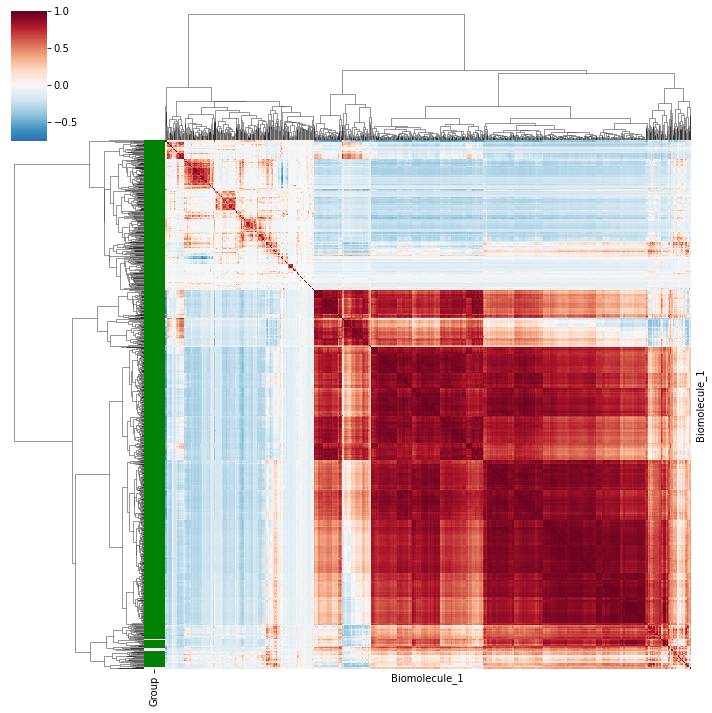

In [72]:
#Transforming to a squared matrix again
PRQ = pd.concat([
    PRmatrix.copy(), 
    PRmatrix.copy().rename(columns={'Biomolecule_1':'Biomolecule_2','Biomolecule_2':'Biomolecule_1'}).loc[:,PRmatrix.columns]
         ]).drop_duplicates()

Rmatrix_fdr = PRQ.copy().pivot(index='Biomolecule_1',columns='Biomolecule_2',values='R (adj_pvalue)')
Rmatrix_fdr = Rmatrix_fdr.loc[Rmatrix_fdr.sum()!=0]
Rmatrix_fdr = Rmatrix_fdr.loc[Rmatrix_fdr.index,Rmatrix_fdr.index].fillna(0)

#Showing only the top correlated features
top_features_fdr = Rmatrix_fdr.index[(Rmatrix_fdr!=0).sum()>alpha_thres*Rmatrix_fdr.shape[0]] #top features based on FDR
Rmatrix_fdr_top = Rmatrix_fdr.copy().loc[top_features_fdr,top_features_fdr] #subsetting R (fdr corrected) matrix

# Heatmap plot
group_dict = dict(zip(data_lip.Group.unique(), "gw"))
row_colors = data_lip.Group.map(group_dict)

g = sns.clustermap(Rmatrix_fdr_top.corr().fillna(0), 
                   cmap="RdBu_r", center=0, 
                   row_colors=row_colors, 
                   yticklabels = False,
                   xticklabels = False);
plt.show()
g.savefig("network_spearman_heatmap.png", dpi=300, transparent=False)

By being more conservative, one will be more sure of the identified associations but a network that is too small may miss biologically important associations (i.e. have many false negatives) and become too sparse to be representative of the biology. This may result in very small communities of nodes, and many dyads and isolated vertices. On the other hand, a network that is too big may display a very high number of associations that are not observed biologically (false positives). It is likely that such networks will display large communities and high density. Think of the balance between Type I and Type II errors. Unfortunately, because this is an unsupervised problem we have no way to compute the false negative rate. This is not always the case: if we are dealing with human proteomics, one possible solution to identify false negatives can be from using a reference map of human protein-protein interactions.

In choosing an appropriate cut-off we will thus rely on the number of potential false positives and the network dimensions. In another section below, we will compare our biological network with a random network and explore how their structure differs both in network properties (e.g. centrality) and communities. Bear in mind that false positives should not have an extensive impact on the network communities if these spurious associations are randomly distributed throughout the network, since the community interrogation algorithms usually compute regions of high density.

We will also look at how the statistically significant correlation coefficients change FDR.

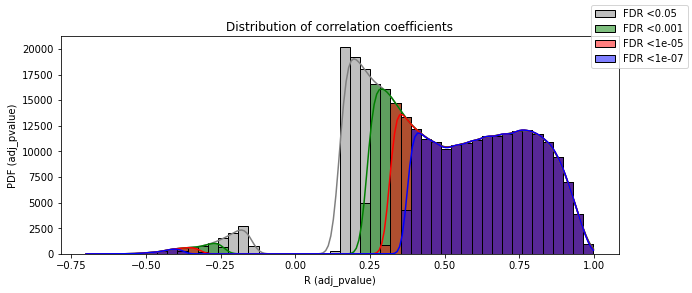

In [78]:
shortPR = PRmatrix.copy().loc[:,['Biomolecule_1','Biomolecule_2', 'R (adj_pvalue)']]
shortPR = shortPR.loc[shortPR.Biomolecule_1!=shortPR.Biomolecule_2]

fig,ax = plt.subplots(figsize=(10,4))

for adj_pvalue in [0.05, 0.001, 0.00001, alpha_thres]:
    ## Plotting R distribution
    temp = PRmatrix.copy()
    temp.loc[:,'R (adj_pvalue)']=temp['R'].copy()
    temp.loc[temp['adj_pvalue']>adj_pvalue,'R (adj_pvalue)']=0
    
    temp = temp.loc[temp.Biomolecule_1!=shortPR.Biomolecule_2]
    
    color = {0.05:'gray',0.001:'green',0.00001:'red', alpha_thres :'blue'}[adj_pvalue]

    
    p = sns.histplot(
        temp['R (adj_pvalue)'][temp['R (adj_pvalue)']!=0], color=color, label='FDR <'+str(adj_pvalue), kde=True, ax=ax, bins=50);
    p.set(ylabel='PDF (adj_pvalue)')

fig.legend()
plt.xlabel('R (adj_pvalue)');
plt.title('Distribution of correlation coefficients');
plt.show()

Predicably, by being more conservative we will be selecting higher absolute correlation coefficients. Larger sample sizes lead to lower nominal and adjusted p-values, and a higher number of statistically significant but milder correlation coefficients. In such cases, one may be more conservative in the significance threshold. 

In [79]:
fdr_significant=PRmatrix.copy().loc[PRmatrix.adj_pvalue<alpha_thres].loc[:,['Biomolecule_1','Biomolecule_2','R','int_type']]
fdr_significant['sig_test']='adj_pvalue'

# Inter count table of the positive correlated lipids and metabolites
inter_count = fdr_significant[fdr_significant.R>0].groupby(['sig_test','int_type'])['R'].agg('count').reset_index()
inter_count

,sig_test,int_type,R
0,adj_pvalue,lipid_lipid,182937
1,adj_pvalue,lipid_metabolite,1358
2,adj_pvalue,metabolite_metabolite,9


In [80]:
print('Total amount of positve correlated interactions:', sum(inter_count.R))

Total amount of positve correlated interactions: 184304


# Network construction and preliminary analysis

We will now build 2 different networks to analyse further:

- The subset of positively correlated biomolecules, where Spearmans rank coefficient is used as weight.
- A random network based on the Erdos-Renyi model, with the same node and edge number of each network.

The random network will be a null-model for our analyses. The idea is that if a certain property found in one of our graphs is reproduced in a random graph, then we do not need to account for any other possible explanations for that feature. In other words, if a property of a graph (e.g. clustering) is not found in a random network, we can assume that it does not appear in our biological network due to randomness.

In [82]:
# Prepares table for being read by igraph
PRmatrix = pd.read_csv('../data/08_association_matrix.tsv', sep="\t")
PRmatrix.loc[PRmatrix['adj_pvalue']>alpha_thres,'R (adj_pvalue)'] = 0
PRmatrix = PRmatrix.loc[PRmatrix['R (adj_pvalue)']!=0,['Biomolecule_1','Biomolecule_2','R (adj_pvalue)']]
PRmatrix = PRmatrix.loc[PRmatrix.Biomolecule_1!=PRmatrix.Biomolecule_2] #drops self correlations

fdr_pos_mat = PRmatrix.loc[PRmatrix['R (adj_pvalue)']>0]
fdr_neg_mat = PRmatrix.loc[PRmatrix['R (adj_pvalue)']<0]

PRmatrix = PRmatrix.loc[PRmatrix.isin(pd.unique(fdr_pos_mat[['Biomolecule_1','Biomolecule_2']].values.flatten())).sum(1)==2,] #selects only nodes also found in the positive network so that we can compare networks of the same sizes
PRmatrix

,Biomolecule_1,Biomolecule_2,R (adj_pvalue)
0,CE(12:0),CE(14:0),0.784893
1,CE(12:0),CE(14:1),0.701835
2,CE(12:0),CE(15:0),0.579732
3,CE(12:0),CE(16:0),0.469324
4,CE(12:0),CE(16:1),0.507372
...,...,...,...
430101,alpha-ketoglutarate,gamma-glutamylglutamate,0.424996
430102,alpha-ketoglutarate,glutamate,0.536250
430113,gamma-glutamylglutamate,glutamate,0.761692
430115,gamma-glutamylglutamate,isoleucine,0.424736


Because this data contains both lipid quantifications and metabolite quantifications, we need to normalize them beforehand. (We didn't need to do this above as we were comparing ranks)

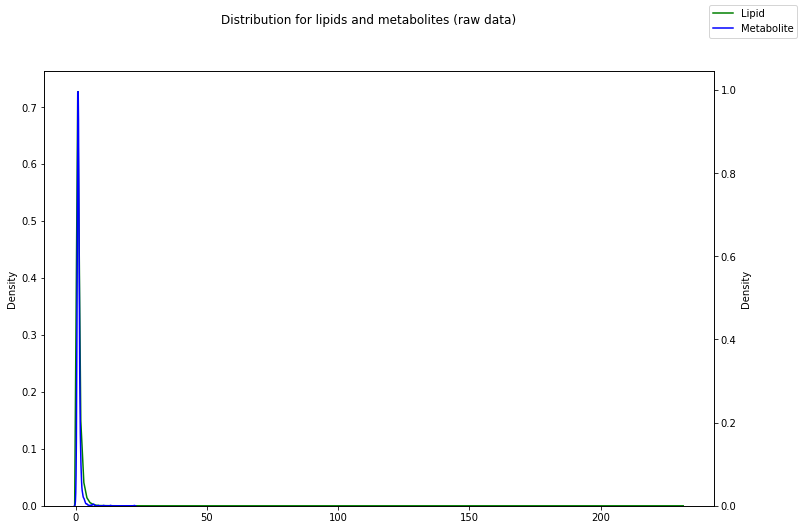

In [83]:
# Plot of data distribution before normalization
fig,ax = plt.subplots(figsize=(12,8))
sns.kdeplot(data_lip.loc[data_lip.Group=='lipid',
                         data_lip.columns!='Group'].values.flatten(),
            color='green', label='Lipid', ax=ax, legend=False)
ax2=ax.twinx()

sns.kdeplot(data_lip.loc[data_lip.Group=='metabolite',
                    data_lip.columns!='Group'].values.flatten(),
            color='blue', label='Metabolite', ax=ax2, legend=False)

fig.suptitle('Distribution for lipids and metabolites (raw data)');
fig.legend();
plt.show()

In [84]:
# Imports and normalizes met and lip data so that we can compute similarities between them
scaled_data = pd.DataFrame(StandardScaler().fit_transform(data_lip.loc[:,data_lip.columns!='Group'].T).T, 
                         columns=data_lip.columns[data_lip.columns!='Group'], 
                         index=data_lip.index)
scaled_data_values = scaled_data.copy()
scaled_data['Group']=data_lip.Group

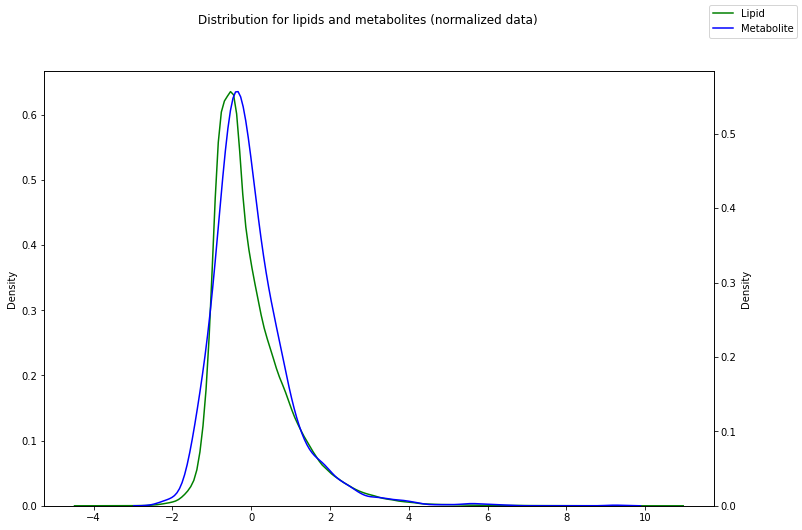

In [85]:
# Plot of data distribution after normalization
fig,ax = plt.subplots(figsize=(12,8))
sns.kdeplot(scaled_data.loc[scaled_data.Group=='lipid',
                         scaled_data.columns!='Group'].values.flatten(),
            color='green', label='Lipid', ax=ax, legend=False)
ax2=ax.twinx()

sns.kdeplot(scaled_data.loc[scaled_data.Group=='metabolite',
                    scaled_data.columns!='Group'].values.flatten(),
            color='blue', label='Metabolite', ax=ax2, legend=False)

fig.suptitle('Distribution for lipids and metabolites (normalized data)');
fig.legend();
plt.show()

The graphs from the dataframes above are generated below

In [86]:
input_ds = scaled_data_values.loc[scaled_data_values.index.isin(pd.unique(fdr_pos_mat[['Biomolecule_1','Biomolecule_2']].values.flatten()))]

# Graph of positive associations, weighted
pos_w = ig.Graph.TupleList(fdr_pos_mat.itertuples(index=False), 
                       directed=False, 
                       weights=True)

# Graph of random network, unweighted, node and edge number based on a network of the same size
random_posw = ig.Graph.Erdos_Renyi(n=input_ds.shape[0], 
                                 m=len(fdr_pos_mat.values), 
                                 directed=False, 
                                 loops=False)

In the next table, we can see that the number of nodes and edges are the same. We also see that the network is fully connected, which is not allways the case. Additionally, we see the networks differ in diameter, average path lenght, clustering coefficient and in the minimum cut. This indicates that our biological network is not random on those parameters. 

In [87]:
# Function to get graph properties, takes a few minutes to run
def graph_prop(input_graph):
    ncount     = nn.vcount()
    ecount     = nn.ecount()
    diameter   = nn.diameter()
    av_path    = nn.average_path_length()
    dens       = nn.density()
    clustering = nn.transitivity_undirected() #this is the global clustering coefficient
    conn       = nn.is_connected()
    min_cut    = nn.mincut_value()
    out        = pd.DataFrame([ncount, ecount, diameter, av_path, dens, clustering, conn, min_cut],
                              index=['node_count','edge_count','diameter','av_path_length',
                                     'density','clustering_coef','connected?','minimum_cut']).T
    return(out)

# Summarizing graph properties
network_stats = pd.DataFrame()
for nn in [pos_w, random_posw]:
    network_stats = pd.concat([network_stats,graph_prop(nn)])
    
network_stats.index = ['pos_w','pos_w_random']
network_stats

,node_count,edge_count,diameter,av_path_length,density,clustering_coef,connected?,minimum_cut
pos_w,917,184304,6,1.71749,0.438834,0.868948,True,1
pos_w_random,917,184304,2,1.56117,0.438834,0.438853,True,351


# Centrality analysis
We'll look into different centrality measures:

- Degree: number of neighbors of a node. In graph theory, the degree of a node of a graph is the number of edges that are incident to the node, and in a multigraph, loops are counted twice.
- Betweenness: measures how many shortest paths in the network pass through a node.
- Closeness: the average length of the shortest paths between a node and all other nodes. 
- Eccentricity: largest shortest path from a node to any other node. Nodes with high eccentricity tend to be on the periphery. How far a node is from the node most distant from it in the graph.
- Eigenvector centrality: a node is more central if its neighbors show a high degree.

Note that many other centrality metrics can be computed. For instance, PageRank and HITS take into account edge directionality to compute what are the most central nodes in a network.

### Degree distribution

Let's start by comparing the degrees of the random network against the biological network. From the figures below it seems that there is no relationship between the degree of the random network and the biological network. 

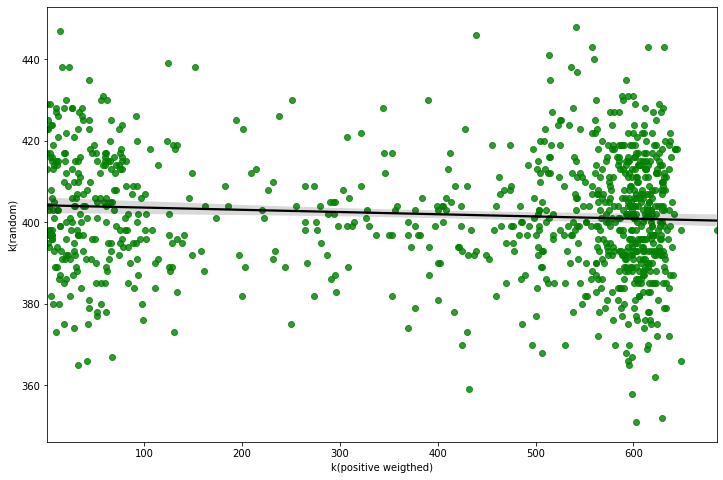

In [88]:
fig,ax = plt.subplots(figsize=(12,8))

sns.regplot(x=pos_w.degree(), 
            y=random_posw.degree(), 
            ax = ax, color='green',
            line_kws = {'color':'black'}, 
           );
#fig.suptitle('Degree distribution for positive w network');
plt.xlabel('k(positive weigthed)')
plt.ylabel('k(random)')
plt.show()

fig.savefig("network_degree_distribution.png", dpi=300, transparent=False)

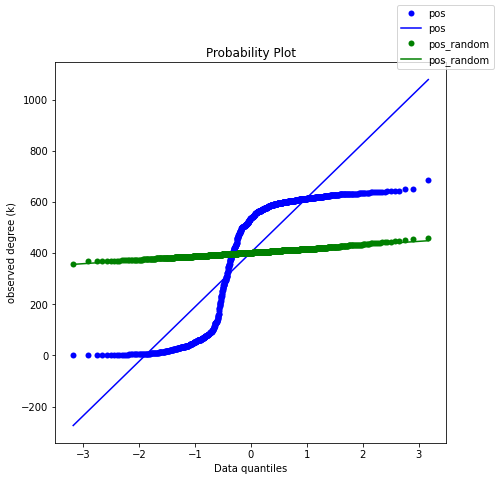

In [31]:
fig, ax = plt.subplots(figsize=(7, 7))
p = sp.stats.probplot(pos_w.degree(), plot=ax)
r = sp.stats.probplot(random_posw.degree(), plot=ax)

col = ['blue','','green','','lightblue','','lightsalmon','','greenyellow','']
for x in np.arange(0,3,2):
    ax.get_lines()[x].set_markerfacecolor(col[x])
    ax.get_lines()[x].set_markeredgewidth(0)
    ax.get_lines()[x+1].set_color(col[x])

fig.legend(labels=['pos','pos','pos_random','pos_random']);

ax.set(xlabel='Data quantiles', ylabel='observed degree (k)')
plt.show()

### Centrality
We will now compare different centrality metrics between the graphs.

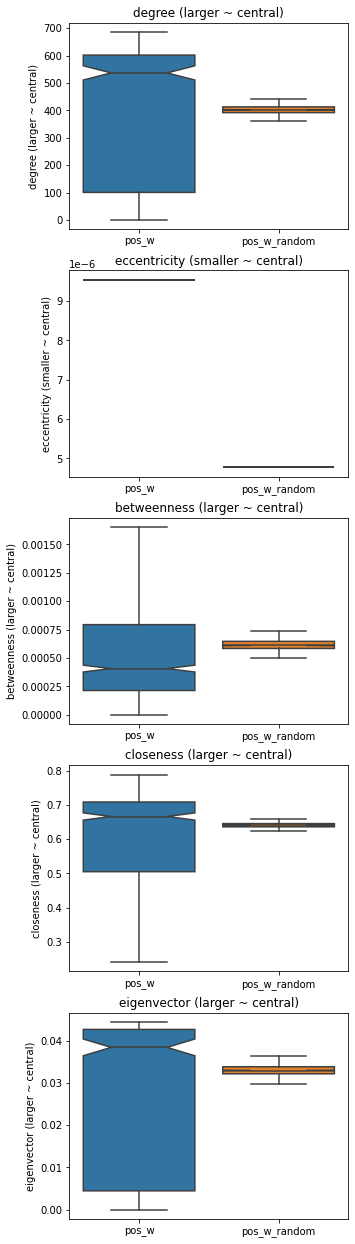

In [95]:
centralities_list = ['degree (larger ~ central)','eccentricity (smaller ~ central)','betweenness (larger ~ central)', 'closeness (larger ~ central)','eigenvector (larger ~ central)']

def combine_raw_centralities():
    """
    Combines centrality metrics
    """
    def centrality_raw(input_graph, graph_name):
        """
        Computes centrality metrics for a graph.
        """
        deg = input_graph.degree(loops=False)
        node_n = input_graph.vcount()
        #scaled to account for network size
        ecc = [(2*x / ((node_n-1)*(node_n-2))) for x in input_graph.eccentricity()]
        btw = [(2*x / ((node_n-1)*(node_n-2))) for x in input_graph.betweenness(directed=False)] 
        eig = input_graph.eigenvector_centrality(directed=False, scale=False)
        
        # For disconnected graphs, computes closeness from the largest connected component
        if(input_graph.is_connected()):
            cls = input_graph.closeness(normalized=True)
        else:
            cls = input_graph.clusters(mode='WEAK').giant().closeness(normalized=True)
        
        out = pd.DataFrame([deg, ecc, btw, cls,eig], index=centralities_list).T
        out['graph'] = graph_name
        out = out.loc[:,np.append(['graph'],out.columns[out.columns!='graph'])]
        
        ##Adds centralities for each node in the network
        input_graph.vs['degree'] = out['degree (larger ~ central)']
        input_graph.vs['eccentricity'] = out['eccentricity (smaller ~ central)']
        input_graph.vs['betweenness'] = out['betweenness (larger ~ central)']
        input_graph.vs['closeness'] = out['closeness (larger ~ central)']
        input_graph.vs['eigenvector'] = out['eigenvector (larger ~ central)']
        
        return(out)
    
    #Computes centralities for all networks
    network_centralities_raw = pd.DataFrame()
    network_centralities_raw = pd.concat([network_centralities_raw,centrality_raw(pos_w,'pos_w')])
    network_centralities_raw = pd.concat([network_centralities_raw,centrality_raw(random_posw,'pos_w_random')])
    return(network_centralities_raw)

network_centralities_raw=combine_raw_centralities()


fig, axes = plt.subplots(nrows=5, figsize=(5,22), sharey='row')
for i, ax in zip(range(6), axes.flat):
    sns.boxplot(
        data = network_centralities_raw, x='graph', y=centralities_list[i],  notch=True, ax=ax, showfliers=False)
    ax.set_title(centralities_list[i])
    ax.set(xlabel='')
plt.show()
fig.savefig("network_centrality.png", dpi=350, transparent=False)

## Community analysis
Communities of nodes may be identified based on different metrics including Modularity or Density. We will look at community detection through modularity.


### Modularity of a lipid network
Below, is the community analysis on the 2 networks by considering the edge weights from the positively associated network. Importantly, this method searches for the largest possible communities for our network, which may not always be the desired. Alternative models such as the Constant Potts Model allow you to identify smaller communities. Should we know that our data has special feature classes, we can compare whether the communities identify those classes by examining them individually, and increasing the resolution if needed.

In [96]:
pos_w_comm = leidenalg.find_partition(pos_w, leidenalg.ModularityVertexPartition, weights=list(fdr_pos_mat["R (adj_pvalue)"]))
random_posw = leidenalg.find_partition(random_posw, leidenalg.ModularityVertexPartition)

The modularity score of the networks is a bit larger than that of the random network.

In [97]:
print("Modularity score of communities in:", "\n",
      "'pos_w': \t\t", np.round(pos_w_comm.modularity,3), '\n',
      "'pos_w_random': \t", np.round(random_posw.modularity,3),
      sep='')

Modularity score of communities in:
'pos_w': 		0.097
'pos_w_random': 	0.027


Comparing the different communities by size:

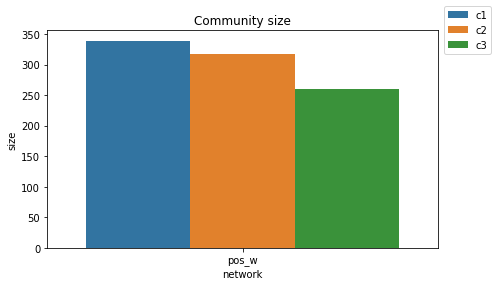

In [102]:
#Compiles biomolecule lists per community
def get_community_table():
    comm_counts=pd.DataFrame()
    feat_lists=pd.DataFrame()
    graph=pos_w
    comm=pos_w_comm
    name='pos_w'

    temp=pd.DataFrame(list(zip(graph.vs['name'],[x+1 for x in comm.membership]))).rename(columns={0:'biomolecule',1:'community'})
    counts=pd.DataFrame(temp.groupby('community')['biomolecule'].agg(len))
    counts.columns=[name]
    comm_counts=pd.concat([comm_counts, counts],1)

    gl=pd.DataFrame(temp.groupby('community')['biomolecule'].apply(list)).reset_index()
    gl['community']=['c'+str(i) for i in gl['community']]
    gl['network']=name
    gl=gl.loc[:,['network','community','biomolecule']]
    feat_lists=pd.concat([feat_lists, gl])
        
    comm_counts.index=['c'+str(i) for i in comm_counts.index]
    return([comm_counts,feat_lists])

#Plotting community sizes
import seaborn as sns
fig, ax = plt.subplots(figsize=(7, 4))
sns.barplot(data = bar_data.T.unstack().reset_index().rename(columns={'level_0':'network','level_1':'community',0:'size'}),
            x='network',
            y='size', 
            hue='community')

ax.legend(loc='right', bbox_to_anchor=(1.15, 1));
ax.set_title('Community size')
plt.xticks(rotation=0)
plt.show()

In [103]:
# Size of the three identified communities
get_community_table()[0].fillna(0).T

,c1,c2,c3
pos_w,339,318,260


In [40]:
get_community_table()[1]

,network,community,feat
0,pos_w,c1,"[CE(12:0), CE(14:0), CE(14:1), CE(16:1), CER(1..."
1,pos_w,c2,"[CE(20:5), DAG(14:0/22:6), DAG(16:0/18:2), DAG..."
2,pos_w,c3,"[CE(15:0), CE(16:0), CE(17:0), CE(18:0), CE(18..."


### Ontology  analysis
The ontology enrichment analysis are performed in LION/web a lipid ontology tool on the communities from the weigthed positive associated network calculated above. 

In [ ]:
# Extract the biochemical list from the three communities
for row, col in get_community_table()[1].iterrows(): 
    if col[0] == "pos_w": 
        if col[1] == "c1":
            c1 = col[2]
        elif col[1] == "c2":
            c2 = col[2]
        elif col[1] == "c3":
            c3 = col[2]

In [ ]:
# Export communities and upload on LION/web - "target-list mode"[http://www.lipidontology.com]
c1_df = pd.DataFrame(c1, columns = [["Biochemicals"]])
c1_df.to_csv('../data/09_c1_biochemicals.csv', index=False)

c2_df = pd.DataFrame(c2, columns = [["Biochemicals"]])
c2_df.to_csv('../data/09_c2_biochemicals.csv', index=False) 

c3_df = pd.DataFrame(c3, columns = [["Biochemicals"]])
c3_df.to_csv('../data/09_c3_biochemicals.csv', index=False) 

## Data tables for Cytoscape 

#### Weigthed network with significant positive associated lipids/metabolites:
Node table includes following info:
- Info on the lipids (Super_pathway) and results from the limmatest (logFC + adj_pvalue)
- Info on the sign. metabolites (Super_pathway)
- Community info for both lipids and metabolites

Edge table includes following info:
- Positive correlated lipids/metabolites
- Adjusted correlation coefficient R (adj_pvalue)

In [43]:
# Prepares association matrix for edge table
assoc_matrix = pd.read_csv('../data/08_association_matrix.tsv', sep="\t")
assoc_matrix1 = assoc_matrix[['Biomolecule_1','Biomolecule_2','adj_pvalue','R (adj_pvalue)','int_type']]
assoc_matrix1.columns = ['Biomolecule_1','Biomolecule_1','adj_pvalue_corr','R (adj_pvalue_corr)','int_type']

In [44]:
# Prepare node table
# Name change of columns
limma_lip1 = limma_lip[['logFC', 'adj.P.Val']]
limma_lip1.columns = ['logFC_limma', 'adj_pval_limma']

# Combining lipid limma data with lipid info data
lip_data = pd.merge(limma_lip1, info_lip, how='left', left_index=True, right_index=True, sort=False) 

# Concatenating limma data from the lipids with database info from the metabolites
frames = [lip_data, info_met[['Super_pathway','Group']]]
info_matrix = pd.concat(frames)

In [45]:
# Add node degree to the info matriz
node_degree = pd.DataFrame(
    {'Biochemicals': pos_w.vs['name'],
     'degree': pos_w.degree()
    })
node_degree = node_degree.set_index('Biochemicals')

# Combining info matrix with node degree matrix
info_matrix1 = pd.concat([node_degree, info_matrix[['logFC_limma', 'adj_pval_limma','Group', 'Super_pathway']]], 
                         axis = 1, join='inner')

In [46]:
info_matrix

,logFC_limma,adj_pval_limma,Super_pathway,Sub_pathway,KEGG_ID,HMDB_ID,Group
Biochemicals,,,,,,,
CE(12:0),0.144906,0.121831,Cholesterol Ester,CE Ester,NaN,HMDB02262,lipid
CE(14:0),0.120583,0.078368,Cholesterol Ester,CE Ester,NaN,HMDB06725,lipid
CE(14:1),0.214494,0.023324,Cholesterol Ester,CE Ester,NaN,HMDB10367,lipid
CE(15:0),0.018334,0.760760,Cholesterol Ester,CE Ester,NaN,HMDB60057,lipid
CE(16:0),0.050907,0.158668,Cholesterol Ester,CE Ester,C11251,HMDB00885,lipid
...,...,...,...,...,...,...,...
glutamate,NaN,NaN,Amino Acid,NaN,NaN,NaN,metabolite
glycerate,NaN,NaN,Carbohydrate,NaN,NaN,NaN,metabolite
isoleucine,NaN,NaN,Amino Acid,NaN,NaN,NaN,metabolite


In [47]:
# Add communities to the association matrix 
community = []
for x in info_matrix1.index:
    if x in c1:
        community += ["c1"]
    elif x in c2:
        community += ["c2"]
    elif x in c3:
        community += ["c3"]

info_matrix1["community"] = community

In [48]:
# Add a column indicating whether the lipid is found to be significant or not between HIV infected with or without MetS
# List with significant lipids found from the exploratory analysis and list with significant metabolites found from prev. study [ref. metabolomics paper]
sign_lip_met = []
for x in info_matrix1.index:
    if x in sign_lipids.index or x in info_met.index:
        sign_lip_met += [x]
    else:
        sign_lip_met += [""]

info_matrix1["sign_lip_met"] = sign_lip_met

In [49]:
# Cytoscape edge and node matrix's
cytoscape_matrix_edges = assoc_matrix1.loc[assoc_matrix1['R (adj_pvalue_corr)']>0]
cytoscape_matrix_nodes = info_matrix1

# Export cytoscape matrix's
cytoscape_matrix_edges.to_csv('../data/08_cytoscape_pos_network_FDR.csv', index=False) 
cytoscape_matrix_nodes.to_csv('../data/08_cytoscape_pos_table_FDR.csv', index=True) 